# Notebook to load in a TANDEM-X and extract a catchment from the pour point

For the artifcats in the DEM I used a Gaussian kernel with the `astropy` convolution function. This smoothes the whole DEM and fills the holes. Smoothing the DEM is a shame but filling the holes is a bonus. Void filling using GANs would be better (https://arxiv.org/pdf/1811.12693.pdf) but this is beyond my pay scale. I then turn to `pysheds` to extract the Kauley Khola catchment from my DEM. (Watch out for this issue though: https://github.com/mdbartos/pysheds/issues/10).

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from pysheds.grid import Grid
from shapely import geometry, ops
from osgeo import gdal, osr, ogr
import fiona
import geopandas as gpd
import seaborn as sns
import pyproj
from pyproj import Transformer
#%matplotlib widget

In [2]:
grdfile = './DEM/tandemxdem.tif'
rio_array = rio.open(grdfile) 

The artifacts apear as large negative values, so I thought to get rid of them just switch them to `nan`. So now I have gaps in my DEM.

In [3]:
data_array = rio_array.read(1).astype(float)
data_array[data_array < 0] = np.nan

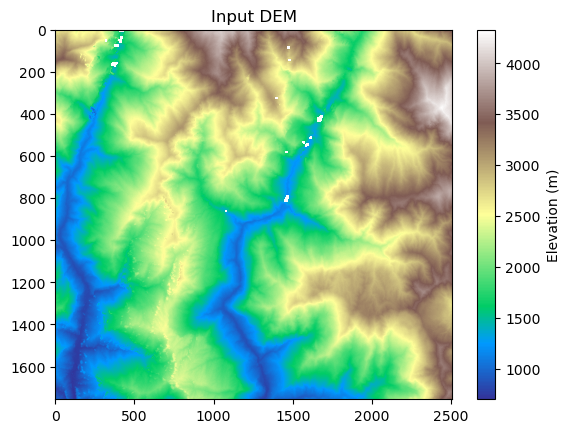

In [4]:
fig=plt.figure()
plt.imshow(data_array, aspect='auto', cmap='terrain')
plt.title('Input DEM')
plt.colorbar(label='Elevation (m)')
plt.show()

Can I use the convolution in astropy to get rid of the nans? https://docs.astropy.org/en/stable/convolution/

In [5]:
# We smooth with a Gaussian kernel with x_stddev=1 (and y_stddev=1)
kernel = Gaussian2DKernel(x_stddev=2)
print('The kernel is an array of size {}'.format(np.shape(kernel)))

The kernel is an array of size (17, 17)


In [6]:
# astropy's convolution replaces the NaN pixels with a kernel-weighted interpolation from their neighbors
astropy_conv = convolve(data_array, kernel)

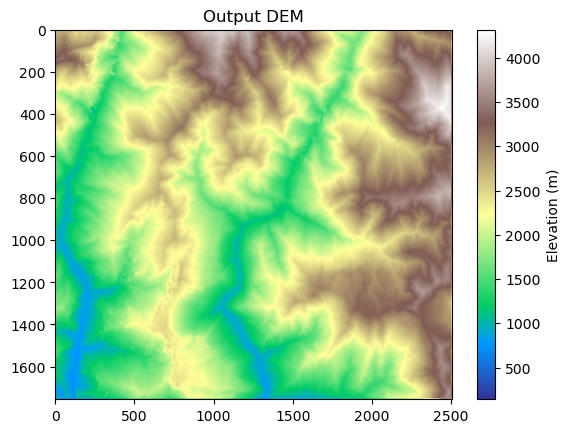

In [7]:
fig=plt.figure()
plt.imshow(astropy_conv, aspect='auto', cmap='terrain')
plt.title('Output DEM')
plt.colorbar(label='Elevation (m)')
plt.show()

All good, but the kernel is applied everywhere, so what else has it done?

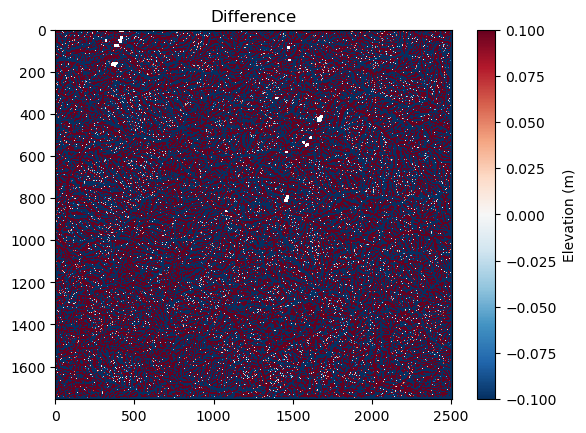

In [8]:
scale = np.max(np.abs(astropy_conv-data_array))
fig=plt.figure()
plt.imshow(astropy_conv-data_array, aspect='auto', cmap='RdBu_r', vmin=-scale, vmax=scale)
plt.title('Difference')
plt.colorbar(label='Elevation (m)')
plt.savefig('diff.png')
plt.show()

So the maximum change in elevation from applying the convolution is 10 cm. Not so bad I think. Worth it for filling the holes?

### Export my new DEM to a tif file

In [9]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    driver.Register()
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outband.SetNoDataValue(-9999)

In [10]:
newRasterfn = './DEM/processed-tandem.tif'
rasterOrigin = (rio_array.transform[2], rio_array.transform[5])
pixelWidth = rio_array.transform[0]
pixelHeight = rio_array.transform[4]  # do the negative later?

array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,astropy_conv)

### Load in the new DEM and clip to my catchment

In [11]:
grdfile = './DEM/processed-tandem.tif'
rio_array = rio.open(grdfile) 

In [12]:
data_array = rio_array.read(1).astype(float)

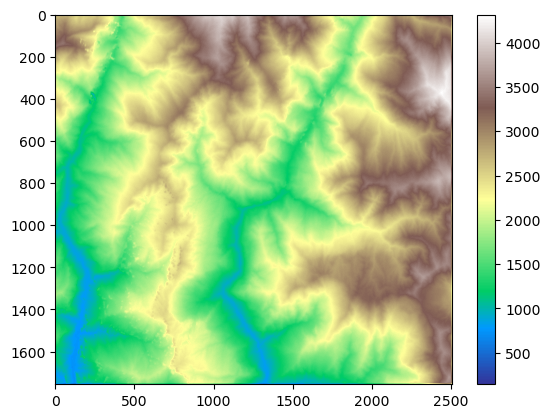

In [13]:
fig=plt.figure()
plt.imshow(data_array, aspect='auto', cmap='terrain')
plt.colorbar()
plt.show()

Looks correct, so load it in as a `pysheds` grid object.

In [14]:
grid = Grid.from_raster('./DEM/processed-tandem.tif')
dem = grid.read_raster('./DEM/processed-tandem.tif')

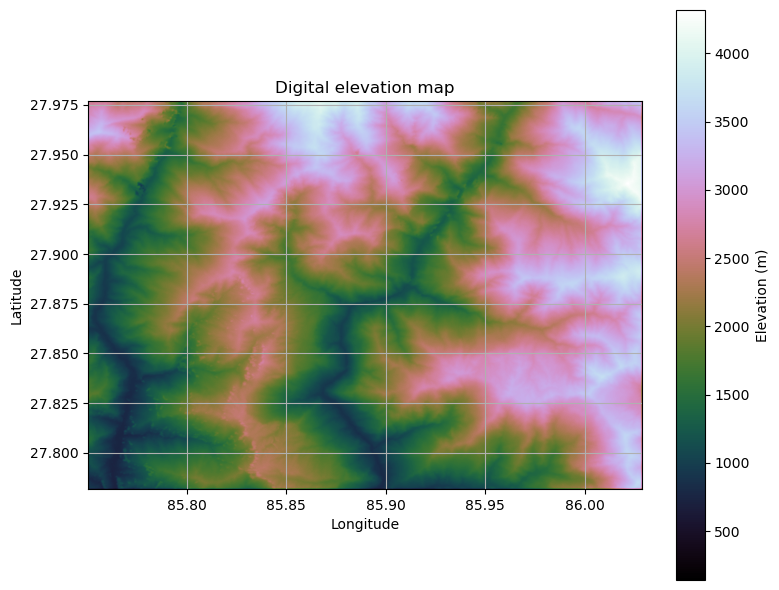

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='cubehelix', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

Following the examples I extract the flow direction and accumulation. The pit filling and resolving of flats is perhaps redundant given what I did to the DEM.

In [16]:
# Fill pits in DEM
pit_filled_dem = grid.fill_pits(dem)

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(pit_filled_dem)
    
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

In [17]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [18]:
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
acc = grid.accumulation(fdir, dirmap=dirmap)

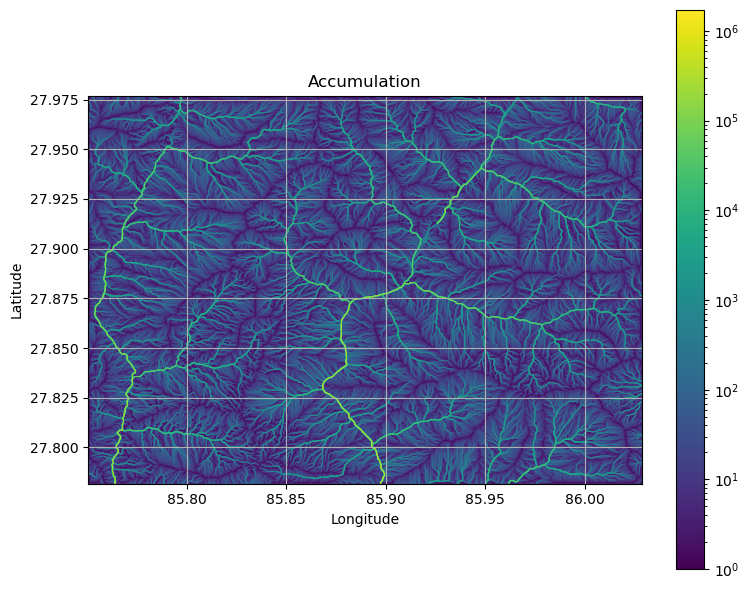

In [19]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(acc, extent=grid.extent, zorder=1, cmap='viridis', norm=colors.LogNorm(vmin=1, vmax=acc.max()))
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Accumulation')
plt.grid(zorder=-1)
plt.tight_layout()

Now I use the plot above to find the x, y coordinates of the pour point for my catchment: 85.881920, 27.873076

In [20]:
x, y = 85.87948, 27.87456

# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, dirmap=dirmap, 
                       xytype='coordinate')

In [21]:
grid.clip_to(catch)
clipped_catch = grid.view(catch, nodata=np.nan)

Text(0.5, 1.0, 'Kahule Khole Catchment')

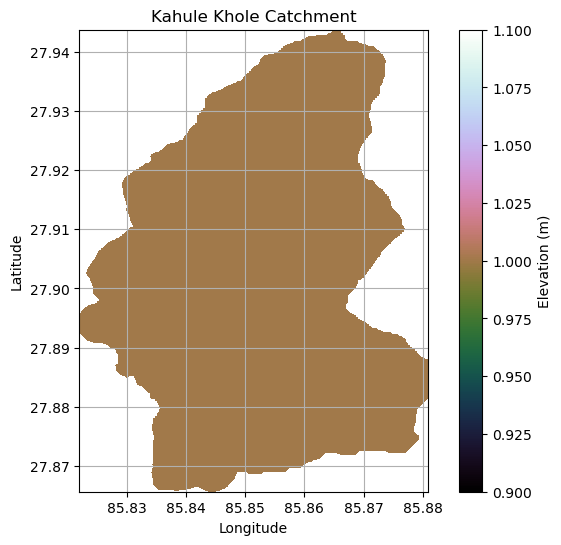

In [22]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
plt.imshow(clipped_catch, extent=grid.extent, cmap='cubehelix', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Kahule Khole Catchment')

Now I have the catchment!

In [23]:
grid.to_raster(dem, './DEM/KauleyKhola.tif', view=True, apply_mask=True, blockxsize=16, blockysize=16)

### Check

In [24]:
grdfile = './DEM/KauleyKhola.tif'
rio_array = rio.open(grdfile) 

In [25]:
data_array = rio_array.read(1).astype(float)
data_array[data_array < 0] = np.nan

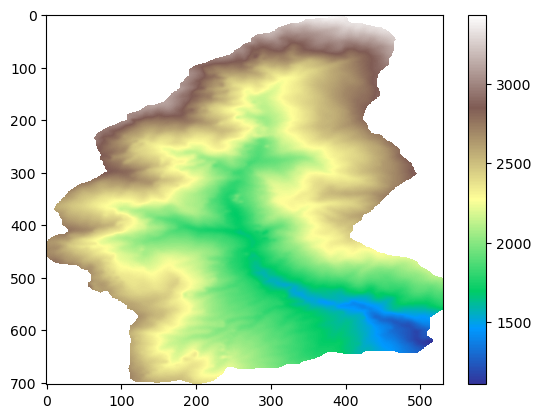

In [26]:
fig=plt.figure()
plt.imshow(data_array, aspect='auto', cmap='terrain')
plt.colorbar()
plt.show()

### Create shapefile of the catchment
https://github.com/mdbartos/pysheds/blob/master/recipes/write_shapefile.ipynb

In [27]:
# Calling grid.polygonize without arguments will default to the catchment mask
shapes = grid.polygonize()

Create a schema and write to file using `fiona`

In [28]:
schema = {
    'geometry': 'Polygon',
    'properties': {'LABEL': 'float:16'}
}

with fiona.open('catchment.shp', 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL' : str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

Read in the shapefile and check it is correct

Text(0.5, 1.0, 'Catchment polygon')

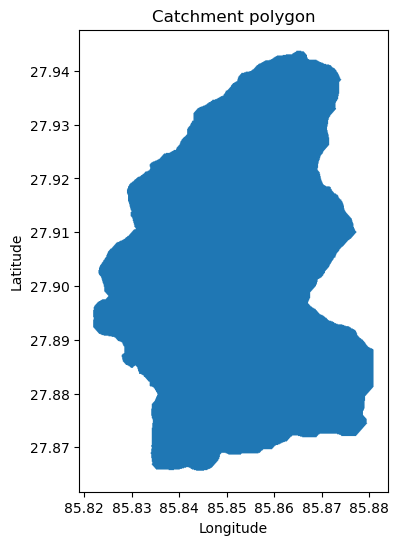

In [29]:
shp = gpd.read_file('catchment.shp')
fig, ax = plt.subplots(figsize=(6,6))
shp.plot(ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Catchment polygon')

Now extract the river network for the catchment and write to a shape file

In [30]:
branches = grid.extract_river_network(fdir, acc > 500, dirmap=dirmap)

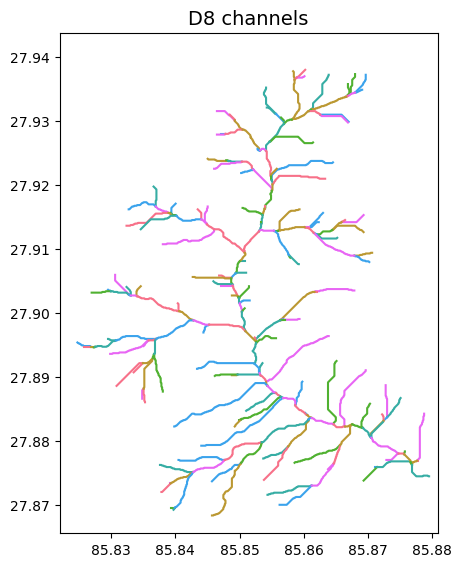

In [31]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('D8 channels', size=14)

In [32]:
schema = {
    'geometry': 'LineString',
    'properties': {}
}

with fiona.open('rivers.shp', 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for branch in branches['features']:
        rec = {}
        rec['geometry'] = branch['geometry']
        rec['properties'] = {}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

Check the shapefile contains the rivers

Text(0.5, 1.0, 'River network')

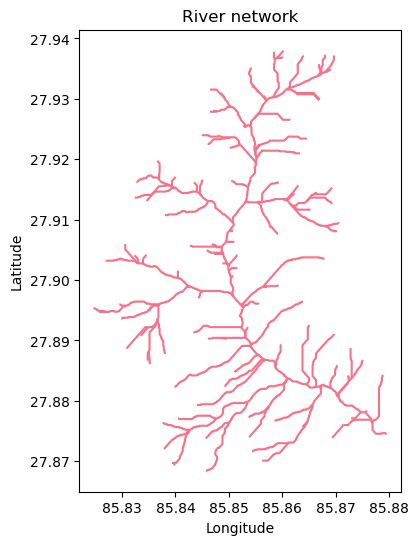

In [33]:
shp = gpd.read_file('rivers.shp')

fig, ax = plt.subplots(figsize=(6,6))
shp.plot(ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('River network')